<a href="https://colab.research.google.com/github/evakato/ComputerVision4/blob/main/cv4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
device = (
    #Nvidia GPU
    "cuda" 
    if torch.cuda.is_available()
    #Apple GPU
    else "mps"
    if torch.backends.mps.is_available()
    #Other
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


1. Import the Fashion MNIST dataset including the data labels. This would import two sets (training set and test set). Create a third set (validation set) by splitting the training set into two (training set and validation set) for validation purposes. Decide what a good ratio of training/validation is, and motivate your choice. You should use the validation set to evaluate the different choices you make when building your CNNs. Keep in mind that the test set will only be used at the very final stage and will not be included in the validation step.

In [3]:
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from matplotlib import pyplot as plt

#NOTE: data is not normalised yet
train_data = datasets.FashionMNIST('Data', download=True, train=True, transform=ToTensor())
test_data = datasets.FashionMNIST('Data', download=True, train=False, transform=ToTensor())

splitlength = [50000,10000] 
#NOTE: This needs to be changed to be calculated using a percentage if we are going to have variable data lenghts (due to e.g. data augmentation)
train_data, val_data = random_split(train_data, splitlength)

batch_size = 32
train_dataloader = DataLoader(train_data, batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size, shuffle=True)

torch.Size([1, 28, 28]) 5


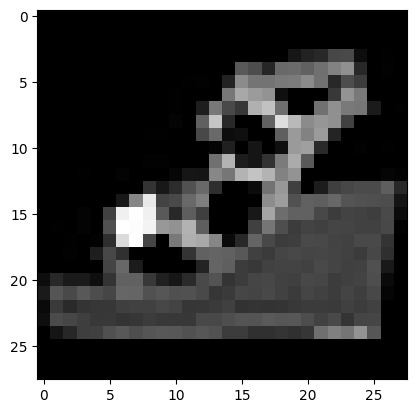

In [4]:
image, label = train_data[0]
print(image.shape, label)
plt.imshow(image[0], cmap = 'gray')

2. Recreate the LeNet-5 architecture as your baseline. The model takes as input a greyscale image of size 28x28x1 and has 10 outputs, one for each class. Make sure all parameters (number of neurons, number and size of kernels) is the same as in the original architecture. You may assume that no zero-padding was applied. The model is trained using cross-entropy loss, Adam optimizer with a learning rate of 0.001. Use torch.nn.init.kaiming_uniform to initialize your weights. Use a batch size of 32, unless your hardware doesn't allow you to. Then reduce the size accordingly.


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.init import kaiming_uniform_, zeros_

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # Convolutional and pooling layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),  # 1 input channel, 6 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), # 6 input channels, 16 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        # Fully connected layers
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),  # 16 channels, 5x5 feature map size 
            #NOTE: isn't this supposed to be 16*5*5?
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),  # 10 output classes
        )

        self.apply(self.weights_init)
    
    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.conv(x)
        # Fully connected layers with ReLU activation
        y = self.dense(x)
        return y

    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

In [6]:
from torchkeras import summary

model = LeNet5()

def check_weights():
    for param in model.parameters():
        print(param.data)

def summarize(model):
    summary(model=model, input_shape=(1,28,28))

summarize(model)


--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Conv2d-1                             [-1, 6, 28, 28]                  156
ReLU-2                               [-1, 6, 28, 28]                    0
AvgPool2d-3                          [-1, 6, 14, 14]                    0
Conv2d-4                            [-1, 16, 10, 10]                2,416
ReLU-5                              [-1, 16, 10, 10]                    0
AvgPool2d-6                           [-1, 16, 5, 5]                    0
Flatten-7                                  [-1, 400]                    0
Linear-8                                   [-1, 120]               48,120
ReLU-9                                     [-1, 120]                    0
Linear-10                                   [-1, 84]               10,164
ReLU-11                                     [-1, 84]                    0
Linear-12                            

In [7]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def train(loader, model, criterion, optimizer):
    size = len(loader.dataset)
    batches = len(loader)
    model.train()
    loss_list = []
    total_loss = 0

    for n, batch in enumerate(tqdm(loader)):
        X,y = batch
        optimizer.zero_grad()
        
        pred = model(X)
        loss = criterion(pred, y)

        loss.backward()
        optimizer.step()

def test(loader, model, criterion):
    size = len(loader.dataset)
    batches = len(loader)
    total_loss = 0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for batch in loader:
            X,y = batch
            pred = model(X)
            
            loss = criterion(pred, y)
            total_loss += loss.item()

            y = y.data.numpy()
            y_true.extend(y)
            pred = pred.argmax(1).data.numpy()
            y_pred.extend(pred)

    loss = total_loss / batches
    accuracy = accuracy_score(y_true, y_pred)

    print(f"loss: {loss}\naccuracy: {accuracy}")
    return y_true, y_pred, loss
        

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd

model = LeNet5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 15
losses_train = []
losses_test = []

def train_test_loop(model, criterion, optimizer, epochs):
    for i in range(epochs):
        print(f"Epoch {i+1}\n----------------")
        print("Training:")
        train(loader=train_dataloader, model=model, criterion=criterion, optimizer=optimizer)
    
        print("Testing (train-set):")
        y_true_train, y_pred_train, loss_train = test(loader=train_dataloader, model=model, criterion=criterion)
        print("Testing (test set):")
        y_true_test, y_pred_test, loss_test = test(loader=val_dataloader, model=model, criterion=criterion)
    
    losses_train.append(loss_train)
    losses_test.append(loss_test)
    return y_true_test, y_pred_test

    print("----------------")

classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

def evaluate(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix = pd.DataFrame(conf_matrix, classes, classes)
    sn.heatmap(conf_matrix, annot=True, fmt= 'g')
    cr = classification_report(y_true, y_pred, target_names=classes)
    print(cr)

def plot_loss(train_losses, test_losses, epochs):
    plt.plot(range(1, epochs+1), train_losses)
    plt.plot(range(1, epochs+1), test_losses)
    plt.show()

#print(losses_train, losses_test)
#evaluate(y_true_test,y_pred_test)
#plot_loss(losses_train, losses_test, epochs)

3. Now create four model variants. Each model may differ from the previous model by only one aspect, such that we can compare each pair of subsequent models pair-wise. An aspect should be a meaningful property, e.g., change the type of one layer (convolution --> pooling, etc.), add one layer, use dropout, change your activation function, change the number or size of your kernels, change the learning rate, etc. No use of any merging, attention, recurrent or locally-connected layers. Your variants should be aimed at getting a better performance. We keep the batch sizes fixed so choose a number and keep it constant for all models (including the baseline model).

In [9]:
'''
options:

Dropout
Learning rate (+++, 0.01 -> 0.001)
Activation function
More/Less layers
 - extra linear layer (+/-, 400 -> 220)
 - extra conv layer
 - more convolution kernels (++, 6->16, 16-> 26)
Pooling type
Normalisation

loss_fn/optimizer/weight init (I dont think this will do much)

grid-search?
'''

'\noptions:\n\nDropout\nLearning rate\nActivation function\nMore/Less layers\nPooling type\nNormalisation\n\nloss_fn/optimizer/weight init (I dont think this will do much)\n\ngrid-search?\n'

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.init import kaiming_uniform_, zeros_

class Var1(nn.Module):
    def __init__(self):
        super(Var1, self).__init__()
        # Convolutional and pooling layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2),  # 1 input channel, 6 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=26, kernel_size=5), # 6 input channels, 16 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        # Fully connected layers
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(26 * 5 * 5, 120),  # 16 channels, 5x5 feature map size 
            #NOTE: isn't this supposed to be 16*5*5?
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),  # 10 output classes
        )

        self.apply(self.weights_init)
    
    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.conv(x)
        # Fully connected layers with ReLU activation
        y = self.dense(x)
        return y

    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

In [17]:
model = Var1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 15
losses_train = []
losses_test = []

train_test_loop(model, criterion, optimizer, epochs)

Epoch 1
----------------
Training:


100%|██████████| 1563/1563 [00:29<00:00, 52.23it/s]


Testing (train-set):
loss: 0.3537599188552708
accuracy: 0.86696
Testing (test set):
loss: 0.3700416944325922
accuracy: 0.8635
Epoch 2
----------------
Training:


100%|██████████| 1563/1563 [00:31<00:00, 49.98it/s]


Testing (train-set):
loss: 0.2794161811685493
accuracy: 0.89808
Testing (test set):
loss: 0.30048965591306503
accuracy: 0.891
Epoch 3
----------------
Training:


100%|██████████| 1563/1563 [00:31<00:00, 49.69it/s]


Testing (train-set):
loss: 0.24359350828352602
accuracy: 0.91244
Testing (test set):
loss: 0.27847238696706944
accuracy: 0.9008
Epoch 4
----------------
Training:


100%|██████████| 1563/1563 [00:31<00:00, 50.22it/s]


Testing (train-set):
loss: 0.22167305914674404
accuracy: 0.91782
Testing (test set):
loss: 0.2709693679461083
accuracy: 0.9045
Epoch 5
----------------
Training:


100%|██████████| 1563/1563 [00:31<00:00, 49.15it/s]


Testing (train-set):
loss: 0.20830174418933742
accuracy: 0.92212
Testing (test set):
loss: 0.27239460402284377
accuracy: 0.9062
Epoch 6
----------------
Training:


100%|██████████| 1563/1563 [00:31<00:00, 50.33it/s]


Testing (train-set):
loss: 0.18063719343854043
accuracy: 0.93326
Testing (test set):
loss: 0.2449706261709761
accuracy: 0.9126
Epoch 7
----------------
Training:


100%|██████████| 1563/1563 [00:31<00:00, 49.45it/s]


Testing (train-set):
loss: 0.19221033279141095
accuracy: 0.92688
Testing (test set):
loss: 0.27516691105815166
accuracy: 0.9026
Epoch 8
----------------
Training:


100%|██████████| 1563/1563 [00:31<00:00, 49.89it/s]


Testing (train-set):
loss: 0.15728868843638413
accuracy: 0.94126
Testing (test set):
loss: 0.24458590276039446
accuracy: 0.9128
Epoch 9
----------------
Training:


100%|██████████| 1563/1563 [00:31<00:00, 49.93it/s]


Testing (train-set):
loss: 0.17692372099313497
accuracy: 0.93206
Testing (test set):
loss: 0.28044097680158125
accuracy: 0.905
Epoch 10
----------------
Training:


100%|██████████| 1563/1563 [00:31<00:00, 49.98it/s]


Testing (train-set):
loss: 0.13818484163525505
accuracy: 0.94854
Testing (test set):
loss: 0.2560162954091931
accuracy: 0.9141
Epoch 11
----------------
Training:


100%|██████████| 1563/1563 [00:32<00:00, 48.50it/s]


Testing (train-set):
loss: 0.12117540622302835
accuracy: 0.95494
Testing (test set):
loss: 0.26105395485810673
accuracy: 0.9132
Epoch 12
----------------
Training:


100%|██████████| 1563/1563 [00:30<00:00, 50.47it/s]


Testing (train-set):
loss: 0.12406152456442296
accuracy: 0.95406
Testing (test set):
loss: 0.26897742317322965
accuracy: 0.9107
Epoch 13
----------------
Training:


100%|██████████| 1563/1563 [00:31<00:00, 49.57it/s]


Testing (train-set):
loss: 0.1036748029112873
accuracy: 0.96062
Testing (test set):
loss: 0.2805904874212879
accuracy: 0.9122
Epoch 14
----------------
Training:


100%|██████████| 1563/1563 [00:33<00:00, 46.88it/s]


Testing (train-set):
loss: 0.08768384928680403
accuracy: 0.96844
Testing (test set):
loss: 0.27633855246511785
accuracy: 0.918
Epoch 15
----------------
Training:


100%|██████████| 1563/1563 [00:33<00:00, 46.31it/s]


Testing (train-set):
loss: 0.09573303788640582
accuracy: 0.96418
Testing (test set):
loss: 0.29196324082055747
accuracy: 0.9128


([5,
  7,
  5,
  5,
  9,
  1,
  7,
  2,
  3,
  3,
  1,
  6,
  9,
  4,
  7,
  2,
  5,
  8,
  3,
  1,
  2,
  6,
  7,
  3,
  0,
  2,
  5,
  1,
  0,
  1,
  9,
  5,
  5,
  3,
  6,
  4,
  0,
  3,
  1,
  7,
  5,
  7,
  3,
  5,
  1,
  2,
  0,
  6,
  6,
  8,
  4,
  8,
  9,
  2,
  3,
  8,
  4,
  4,
  9,
  1,
  0,
  6,
  0,
  7,
  3,
  5,
  9,
  8,
  5,
  7,
  1,
  4,
  4,
  1,
  6,
  9,
  9,
  3,
  9,
  1,
  5,
  4,
  6,
  1,
  7,
  6,
  8,
  6,
  8,
  1,
  0,
  5,
  2,
  0,
  8,
  0,
  3,
  9,
  1,
  6,
  1,
  1,
  5,
  6,
  5,
  9,
  8,
  4,
  6,
  0,
  6,
  0,
  8,
  5,
  3,
  8,
  5,
  6,
  1,
  1,
  8,
  2,
  2,
  7,
  0,
  0,
  7,
  1,
  7,
  8,
  5,
  2,
  2,
  2,
  1,
  7,
  9,
  9,
  3,
  5,
  9,
  0,
  7,
  6,
  0,
  8,
  6,
  2,
  0,
  9,
  2,
  7,
  6,
  1,
  4,
  8,
  7,
  2,
  4,
  3,
  7,
  0,
  9,
  9,
  5,
  4,
  7,
  0,
  0,
  0,
  8,
  3,
  4,
  6,
  3,
  4,
  6,
  3,
  6,
  8,
  8,
  2,
  2,
  9,
  4,
  9,
  5,
  1,
  5,
  8,
  7,
  2,
  9,
  3,
  5,
  8,
  0,
  5,
  5,
  9,
